In [2]:
"""
FEniCS tutorial demo program: Incompressible Navier-Stokes equations
for channel flow (Poisseuille) on the unit square using the
Incremental Pressure Correction Scheme (IPCS).

  u' + u . nabla(u)) - div(sigma(u, p)) = f
								 div(u) = 0
"""

from __future__ import print_function
from fenics import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt

In [3]:
T = 10.0           # final time
num_steps = 50    # number of time steps
dt = T / num_steps # time step size
mu = 1             # kinematic viscosity
rho = 1            # density

To create a Mesh, either use one of the built-in meshes https://fenicsproject.org/docs/dolfin/1.4.0/python/demo/documented/built-in_meshes/python/documentation.html or create a custom one. 

Notice that the class PolygonalMeshGenerator has been deprecated so it's no longer available. Instead, we need to call generate_mesh on a custom domain. Custom domains are generated by combining through union, intersection or difference elementary shapes. Custom meshes require the package mshr https://bitbucket.org/benjamik/mshr/src/master/ , which comes if FEniCS is installed system-wide (i.e. through apt, not through Anaconda). Elementary shapes are, which are dolfin.Point, Rectangle, Circle, Ellipse, Polygon: https://bitbucket.org/benjamik/mshr/wiki/browse/API

The two next cells are **alternatives** implementing a built-in mesh over a unit square or custom one.

In [108]:
# Create mesh
mesh = UnitSquareMesh(16, 16)

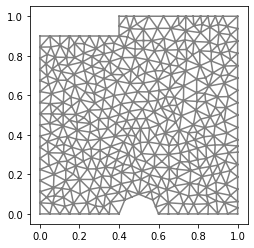

In [83]:
domain = Rectangle(Point(0., 0.), Point(1., 1.)) - \
         Circle(dolfin.Point(0.5, 0.0), 0.1) - \
         Rectangle(dolfin.Point(0.0, 0.9), dolfin.Point(0.4, 1.0)) 

mesh = generate_mesh(domain, 16, "cgal")
plot(mesh)

In [109]:
# Define function spaces
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

Obs. that "Custom expressions defined in Python are no longer subclasses of Expression (as documented in https://fenicsproject.org/docs/dolfin/1.6.0/python/programmers-reference/functions/expression/Expression.html), but, instead, of a separate class, UserExpression". That's why class `class MyExpression(Expression)` must be
`class MyExpression(UserExpression)` instead.

In [124]:
# Define boundaries
left  = 'near(x[0], 0)'
right_lower = 'near(x[0], 1) && x[1] < 1/4'
right_upper = 'near(x[0], 1) && x[1] > 1/4'
above = 'near(x[1], 1)'
below = 'near(x[1], 0)'

class MyExpression0(UserExpression):
    def eval(self, value, x):
        #value[0] = 0
        #value[1] = 0
        
        #if(x[1] > 0 and x[1] < 1/4):
        value[0] = -exp(-(x[1]-1/8)*(x[1]-1/8))
        value[1] = 0
        
    def value_shape(self): #no idea what this does!! 
        return (2,)
    
#Expression('-sin(2*pi*x[1])', degree=2)
f0 = MyExpression0()

# Define boundary conditions
#bcu_right = DirichletBC(V.sub(0), Expression('-sin(2*pi*x[1])', degree=2), right)
#bcu_right = DirichletBC(V, Expression(('-sin(2*pi*x[1])', 0), degree=2), right)
#bcu_right_lower = DirichletBC(V, f0, right_lower)
bcu_right_upper = DirichletBC(V, Constant((-2.0, 0.0)), right_upper)
bcu_right_lower = DirichletBC(V, Constant((-20.0, 0.0)), right_lower)
bcu_left  = DirichletBC(V, Constant((0.0, 0.0)), left)
bcu_above = DirichletBC(V, Constant((0.0, 0.0)), above)
bcu_below  = DirichletBC(V, Constant((0.0, 0.0)), below)

bcp_above = DirichletBC(Q, Constant(0), above)
bcp_below = DirichletBC(Q, Constant(0), below)
#bcp_outflow = DirichletBC(Q, Expression('sin(2*pi*x[1])', degree=2), outflow)

#Group them together for later usage
bcu = [bcu_right_upper, bcu_right_lower, bcu_left, bcu_above, bcu_below]
bcp = [bcp_above, bcp_below]

In [125]:
# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

# Define expressions used in variational forms
U   = 0.5*(u_n + u)
n   = FacetNormal(mesh)
f   = Constant((0, 0))
k   = Constant(dt)
mu  = Constant(mu)
rho = Constant(rho)

In [126]:
# Define strain-rate tensor
def epsilon(u):
	return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
	return 2*mu*epsilon(u) - p*Identity(len(u))

In [127]:
# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx + \
     rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
     + inner(sigma(U, p_n), epsilon(v))*dx \
     + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
     - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

In [128]:
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

[None, None]

In [129]:
# Time-stepping
t = 0
for n in range(num_steps):
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    # Compute error
    u_e = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
    u_e = interpolate(u_e, V)
    error = np.abs(u_e.vector().get_local() - u_.vector().get_local()).max()
    #print('t = %.2f: error = %.3g' % (t, error))
    #print('max u:', u_.vector().get_local().max())

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)    

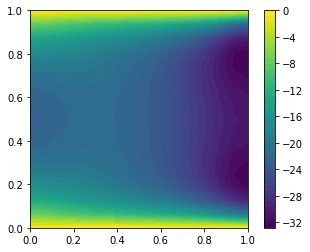

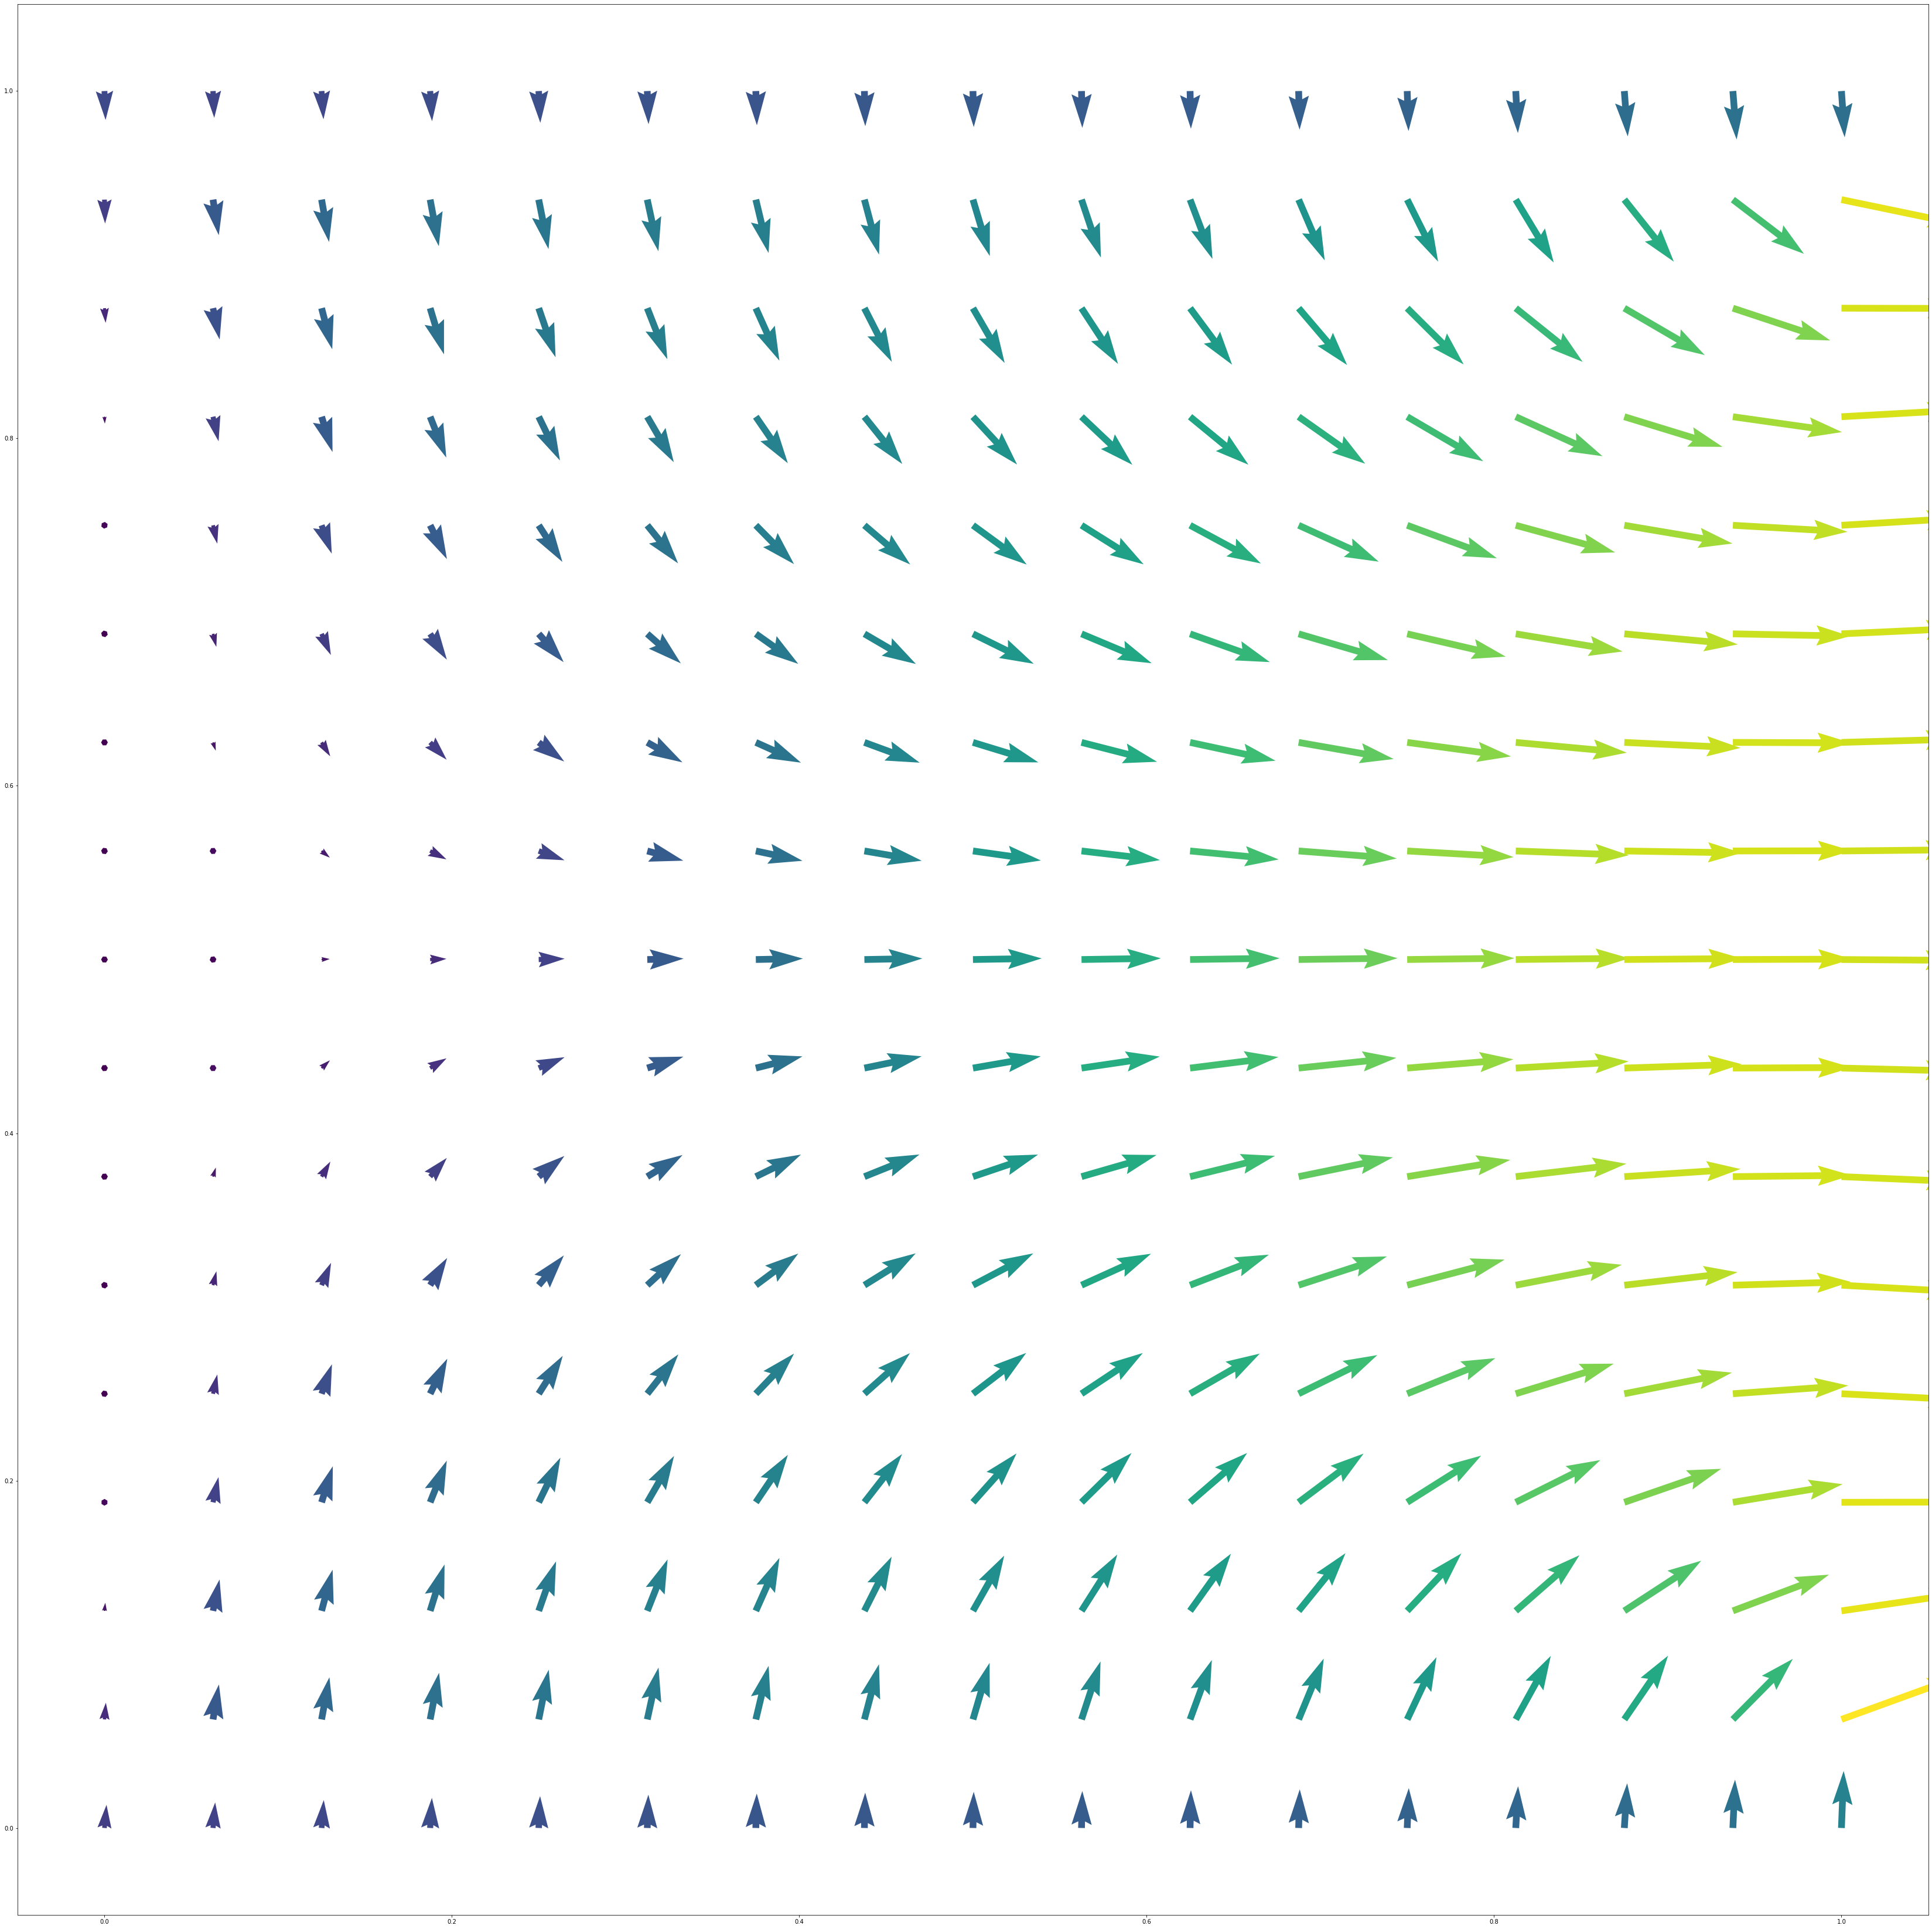

In [130]:
# Plot solution
fig = plot(p_)
plt.colorbar(fig)

plt.show()

fig = plt.figure(figsize=(80, 60))
plot(u_)
#plt.colorbar(fig)
plt.show()